In [6]:
!pip install torchvision==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━

In [7]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq transformers==4.4.2 --progress-bar off
!pip install -qqq datasets==2.20.0 --progress-bar off
!pip install -qqq accelerate==0.31.0 --progress-bar off
!pip install -qqq bitsandbytes==0.43.1 --progress-bar off
!pip install -qqq peft==0.11.1 --progress-bar off
!pip install -qqq trl==0.9.4 --progress-bar off
!pip install -qqq colored==2.2.4 --progress-bar off
!pip uninstall -y bitsandbytes triton
!pip install --no-cache-dir bitsandbytes triton

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  ERROR: Failed building wheel for tokenizers
ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.5.0 which is incompatible.
s3fs 2024.9.0 requires fsspec==2024.9.0.*, but you have fsspec 2024.5.0 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.1.0 which is incompatible.
Found existing installation: bitsandbytes 0.43.1
Uninstalling bitsandbytes-0.43.1:
  Successfully uninstalled bitsandbytes-0.43.1
Found existing installation: triton 2.1.0
Uninstalling triton-2.1.0:
  Successfully uninstalled triton-2.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
NEW_MODEL = "Llama-3.2-1B-Instruct-Finance-RAG"

In [15]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128264, 2048)

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Embedding(128264, 2048)

In [5]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,

In [10]:
dataset = load_dataset("virattt/financial-qa-10K")
dataset

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [11]:
rows = []
for item in dataset["train"]:
    rows.append(
        {
            "question": item["question"],
            "context": item["context"],
            "answer": item["answer"],
        }
    )
df = pd.DataFrame(rows)

In [12]:
df.isnull().value_counts()

question  context  answer
False     False    False     7000
Name: count, dtype: int64

In [17]:
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [18]:
df["text"] = df.apply(format_example, axis=1)

In [19]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )
     
df["token_count"] = df.apply(count_tokens, axis=1)

df.head()

,question,context,answer,text,token_count
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.,<|begin_of_text|><|start_header_id|>system<|en...,96
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...,<|begin_of_text|><|start_header_id|>system<|en...,192
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.,<|begin_of_text|><|start_header_id|>system<|en...,94
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...,<|begin_of_text|><|start_header_id|>system<|en...,118
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...,<|begin_of_text|><|start_header_id|>system<|en...,104


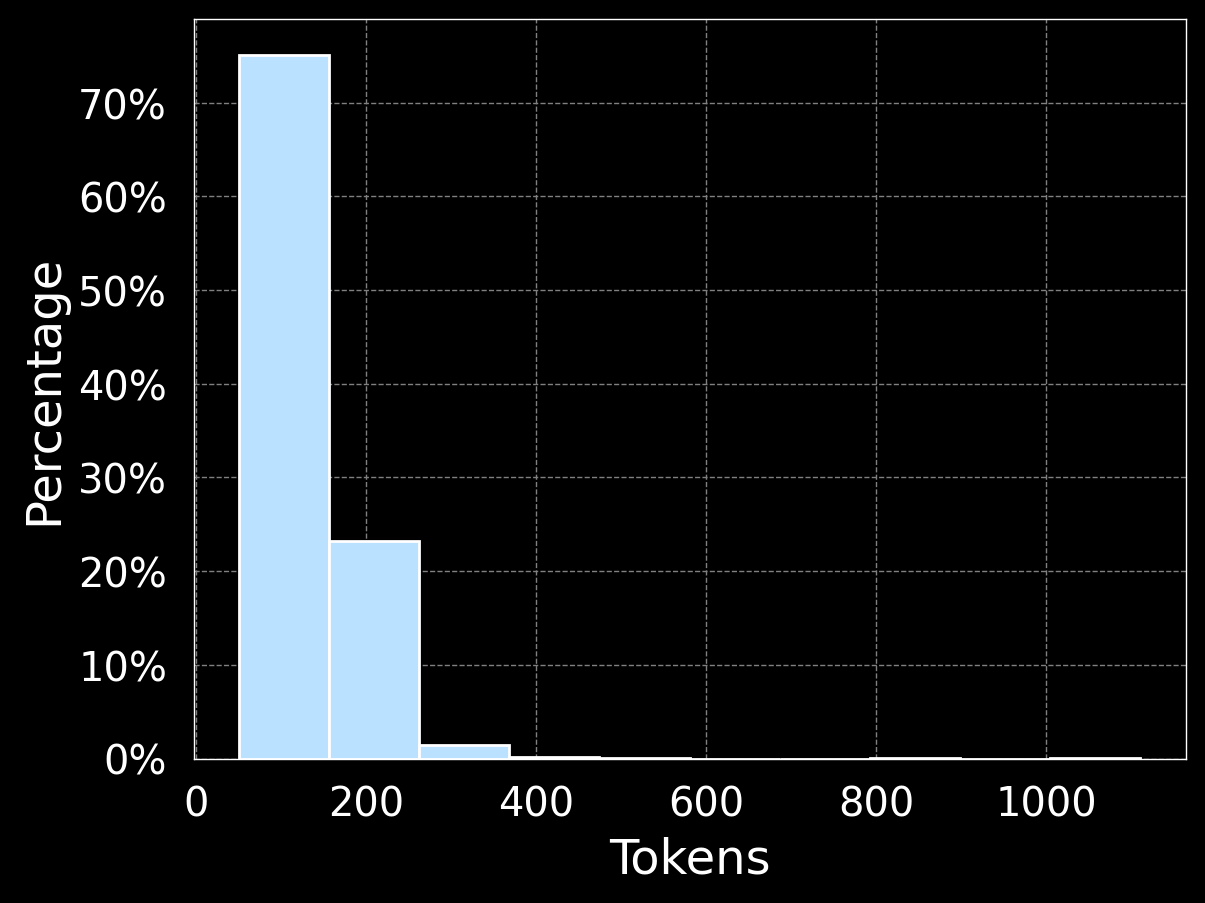

In [20]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show();

In [21]:
df = df[df.token_count < 512]
df = df.sample(3000)

train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

train.sample(n=2000).to_json("train.json", orient="records", lines=True)
val.sample(n=200).to_json("val.json", orient="records", lines=True)
test.sample(n=100).to_json("test.json", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [22]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
 

In [23]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [24]:
OUTPUT_DIR = "experiments"

%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

<IPython.core.display.Javascript object>

In [25]:
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=10,
    learning_rate=2e-5,
    fp16=True,  # or bf16=True,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  
        "append_concat_token": False, 
    },
    seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:402: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [26]:
model.train()  

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128264, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

In [27]:
trainer.save_model(NEW_MODEL)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:209: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [28]:
import torch
torch.cuda.empty_cache()

tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)
 

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

In [29]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Patel47/Llama-3.2-1B-Instruct-Finance-RAG/commit/091c99e5b3fd62b61feae0d656dc9e2d2eca80ac', commit_message='Upload LlamaForCausalLM', commit_description='', oid='091c99e5b3fd62b61feae0d656dc9e2d2eca80ac', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Patel47/Llama-3.2-1B-Instruct-Finance-RAG', endpoint='https://huggingface.co', repo_type='model', repo_id='Patel47/Llama-3.2-1B-Instruct-Finance-RAG'), pr_revision=None, pr_num=None)

In [30]:
tokenizer.push_to_hub(NEW_MODEL)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Patel47/Llama-3.2-1B-Instruct-Finance-RAG/commit/7501d7de044ed96cffbccda488ef945a278b4c36', commit_message='Upload tokenizer', commit_description='', oid='7501d7de044ed96cffbccda488ef945a278b4c36', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Patel47/Llama-3.2-1B-Instruct-Finance-RAG', endpoint='https://huggingface.co', repo_type='model', repo_id='Patel47/Llama-3.2-1B-Instruct-Finance-RAG'), pr_revision=None, pr_num=None)

## Model Evaluation

In [31]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 200
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [32]:
MODEL_NAME = "Patel47/Llama-3.2-1B-Instruct-Finance-RAG"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/54.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [33]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

Device set to use cuda:0


In [52]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use the information to answer the question. Frame your answer in a clear and concise manner.",
        },
        {"role": "user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [53]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 09 Feb 2025

Use the information to answer the question. Frame your answer in a clear and concise manner.<|eot_id|><|start_header_id|>user<|end_header_id|>

How much did the after-tax earnings of the real estate brokerage decrease in 2023, and what were the primary factors for this decrease?

Information:

```
After-tax earnings of real estate brokerage decreased $87 million (87.0%) in 2023 compared to 2022. The decrease reflected lower brokerage services revenues and margins, primarily due to a 19% reduction in closed brokerage transaction volumes, as well as lower mortgage services revenues and margins from a 28% decrease in closed transaction volumes. These declines were attributable to the impact of rising interest rates and lower existing home sales.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [54]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     The after-tax earnings of the real estate brokerage decreased by $87 million, or 87.0%, in 2023. The primary factors for this decrease were lower brokerage services revenues and margins, mainly due to a 19% reduction in closed brokerage transaction volumes, as well as lower mortgage services revenues and margins due to a 28% decrease in closed transaction volumes. These declines were influenced by rising interest rates and lower existing home sales.
prediction: The after-tax earnings of the real estate brokerage decreased by $87 million in 2023, down 87.0%. The primary factors for this decrease were:

1. Lower brokerage services revenues
2. Lower margins from lower mortgage services revenues

CPU times: user 2.27 s, sys: 2.81 ms, total: 2.27 s
Wall time: 2.27 s


In [55]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 09 Feb 2025

Use the information to answer the question. Frame your answer in a clear and concise manner.<|eot_id|><|start_header_id|>user<|end_header_id|>

How much did Gilead's net income amount to in 2023?

Information:

```
Net income attributable to Gilead was $5.7 billion in 2023, compared to $4.6 billion in 2022.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [56]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     $5.7 billion
prediction: Gilead's net income in 2023 was $5.7 billion.

CPU times: user 943 ms, sys: 1.9 ms, total: 945 ms
Wall time: 943 ms


In [57]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 09 Feb 2025

Use the information to answer the question. Frame your answer in a clear and concise manner.<|eot_id|><|start_header_id|>user<|end_header_id|>

How does Hewlett Packard Enterprise recognize revenue from its products and services?

Information:

```
The majority of our revenue is derived from sales of products and services and the associated support and maintenance, and such revenue is recognized when, or as, control of promised products or services is transferred to the customer at the transaction price.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [58]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     Hewlett Packard Enterprise recognizes revenue when control of the products or services is transferred to the customer at the transaction price, which is adjusted for variable considerations such as rebates and discounts.
prediction: Hewlett Packard Enterprise (HP) recognizes revenue from its products and services when it transfers control of the promised products or services to the customer at the transaction price.

CPU times: user 1.56 s, sys: 4.59 ms, total: 1.56 s
Wall time: 1.56 s


In [59]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "question": row["question"],
            "context": row["context"],
            "prompt": prompt,
            "answer": row["answer"],
            "untrained_prediction": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

100%|██████████| 100/100 [04:46<00:00,  2.87s/it]


In [60]:
predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])

100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


In [62]:
predictions_df["trained_prediction"] = predictions

In [63]:
predictions_df.to_csv("predictions.csv", index=None)

In [64]:
sample = predictions_df.sample(n=20)

In [65]:
for i, row in sample.head(n=10).reset_index().iterrows():
    print(f"{Fore.DARK_VIOLET_1A}{Back.WHITE}Example {i + 1}{Style.reset}")
    response = f"""
{Fore.BLUE}answer:{Style.reset} {row['answer']}

{Fore.GREEN}trained:{Style.reset} {row['trained_prediction']}

{Fore.DARK_ORANGE}untrained:{Style.reset} {row['untrained_prediction']}
"""
    print(response)

Example 1

answer: Long-term investments with maturities greater than twelve months but less than 37 months, excluding those made through the Company’s Impact Investment Fund, are classified as available-for-sale and are reported at fair value using the specific identification method.

trained: The classification and reporting method for long-term investments with maturities greater than 12 months but less than 37 months, excluding those made through the Company's Impact Investment Fund, is as follows:

* **Classification:** Available-for-sale (AFS)
* **Reporting Method:** Fair value

untrained: This question does not provide enough information to answer it. The text you provided does not mention what is being asked, it seems to be a statement about long-term investments with maturities between 12-37 months, excluding those made through the Company's Impact Investment Fund.

Example 2

answer: The focus of HPE's Intelligent Edge business segment is to provide secure edge-to-cloud conne